In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from importlib import reload

import pickle
import time

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf
import util_func as uf

import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,network,connectivity,dynamics_np
from dev_ori_sel_RF.tools import misc,update_params_dict,gen_gaussian_random_field

2023-08-02 15:36:50.636516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Please install GPU version of TF


# Define functions to simulate dynamics

In [3]:
from scipy.integrate import solve_ivp

def fio_rect(x):
#     x[x<0] = 0
#     return x
    return np.fmax(x,0)

def dynamics_system(y,inp_ff,Wrec,\
                    gamma_rec,gamma_ff,N,tau):
#     argE = gamma_rec * np.dot(Wrec[:N],y) + gamma_ff * inp_ff[0]
#     argI = gamma_rec * np.dot(Wrec[N:],y) + gamma_ff * inp_ff[1]
#     return 1./tau*( -y + fio_rect(np.concatenate([argE,argI])))
    arg = gamma_rec * np.dot(Wrec,y) + gamma_ff * inp_ff.flatten()
    return 1./tau*( -y + fio_rect(arg))

def integrate(y0,inp,dt,Nt,gamma_rec=1.02):
    y = y0
    for t_idx in range(Nt):
        out = dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
        dy = out
        y = y + dt*dy
    return np.array([y[:N4**2].reshape((N4,N4)),y[N4**2:].reshape((N4,N4))])
#     def ode_fun(t,y):
#         return dynamics_system(y,inp,W4to4,gamma_rec,1.0,N4*N4,1.0)
#     sol = solve_ivp(ode_fun,[0,dt*Nt],y0,method='RK23',first_step=dt)
#     return np.array([sol.y[:N4**2,-1].reshape((N4,N4)),sol.y[N4**2:,-1].reshape((N4,N4))])

# Construct homogeneous recurrent weights

In [4]:
config_name = "big_homo"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name)
    
# W4 = connectivity.Connectivity_2pop((N4,N4),(N4,N4),\
#                                     (N4,N4), (N4,N4),\
#                                     random_seed=config_dict["random_seed"],\
#                                     Nvert=1, verbose=True)

# start = time.process_time()

# W4to4,arbor4to4 = W4.create_matrix_2pop(config_dict["W4to4_params"],config_dict["W4to4_params"]["Wrec_mode"])

# print('Creating homogenous recurrent connectivity took',time.process_time() - start,'s')
# np.save('homo_W4to4_N4={:d}'.format(N4),W4to4)

W4to4 = np.load('homo_W4to4_N4={:d}.npy'.format(N4))

MISC params_dict params_big_homo {'Nret': 60, 'Nlgn': 60, 'N4': 60, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ecce

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

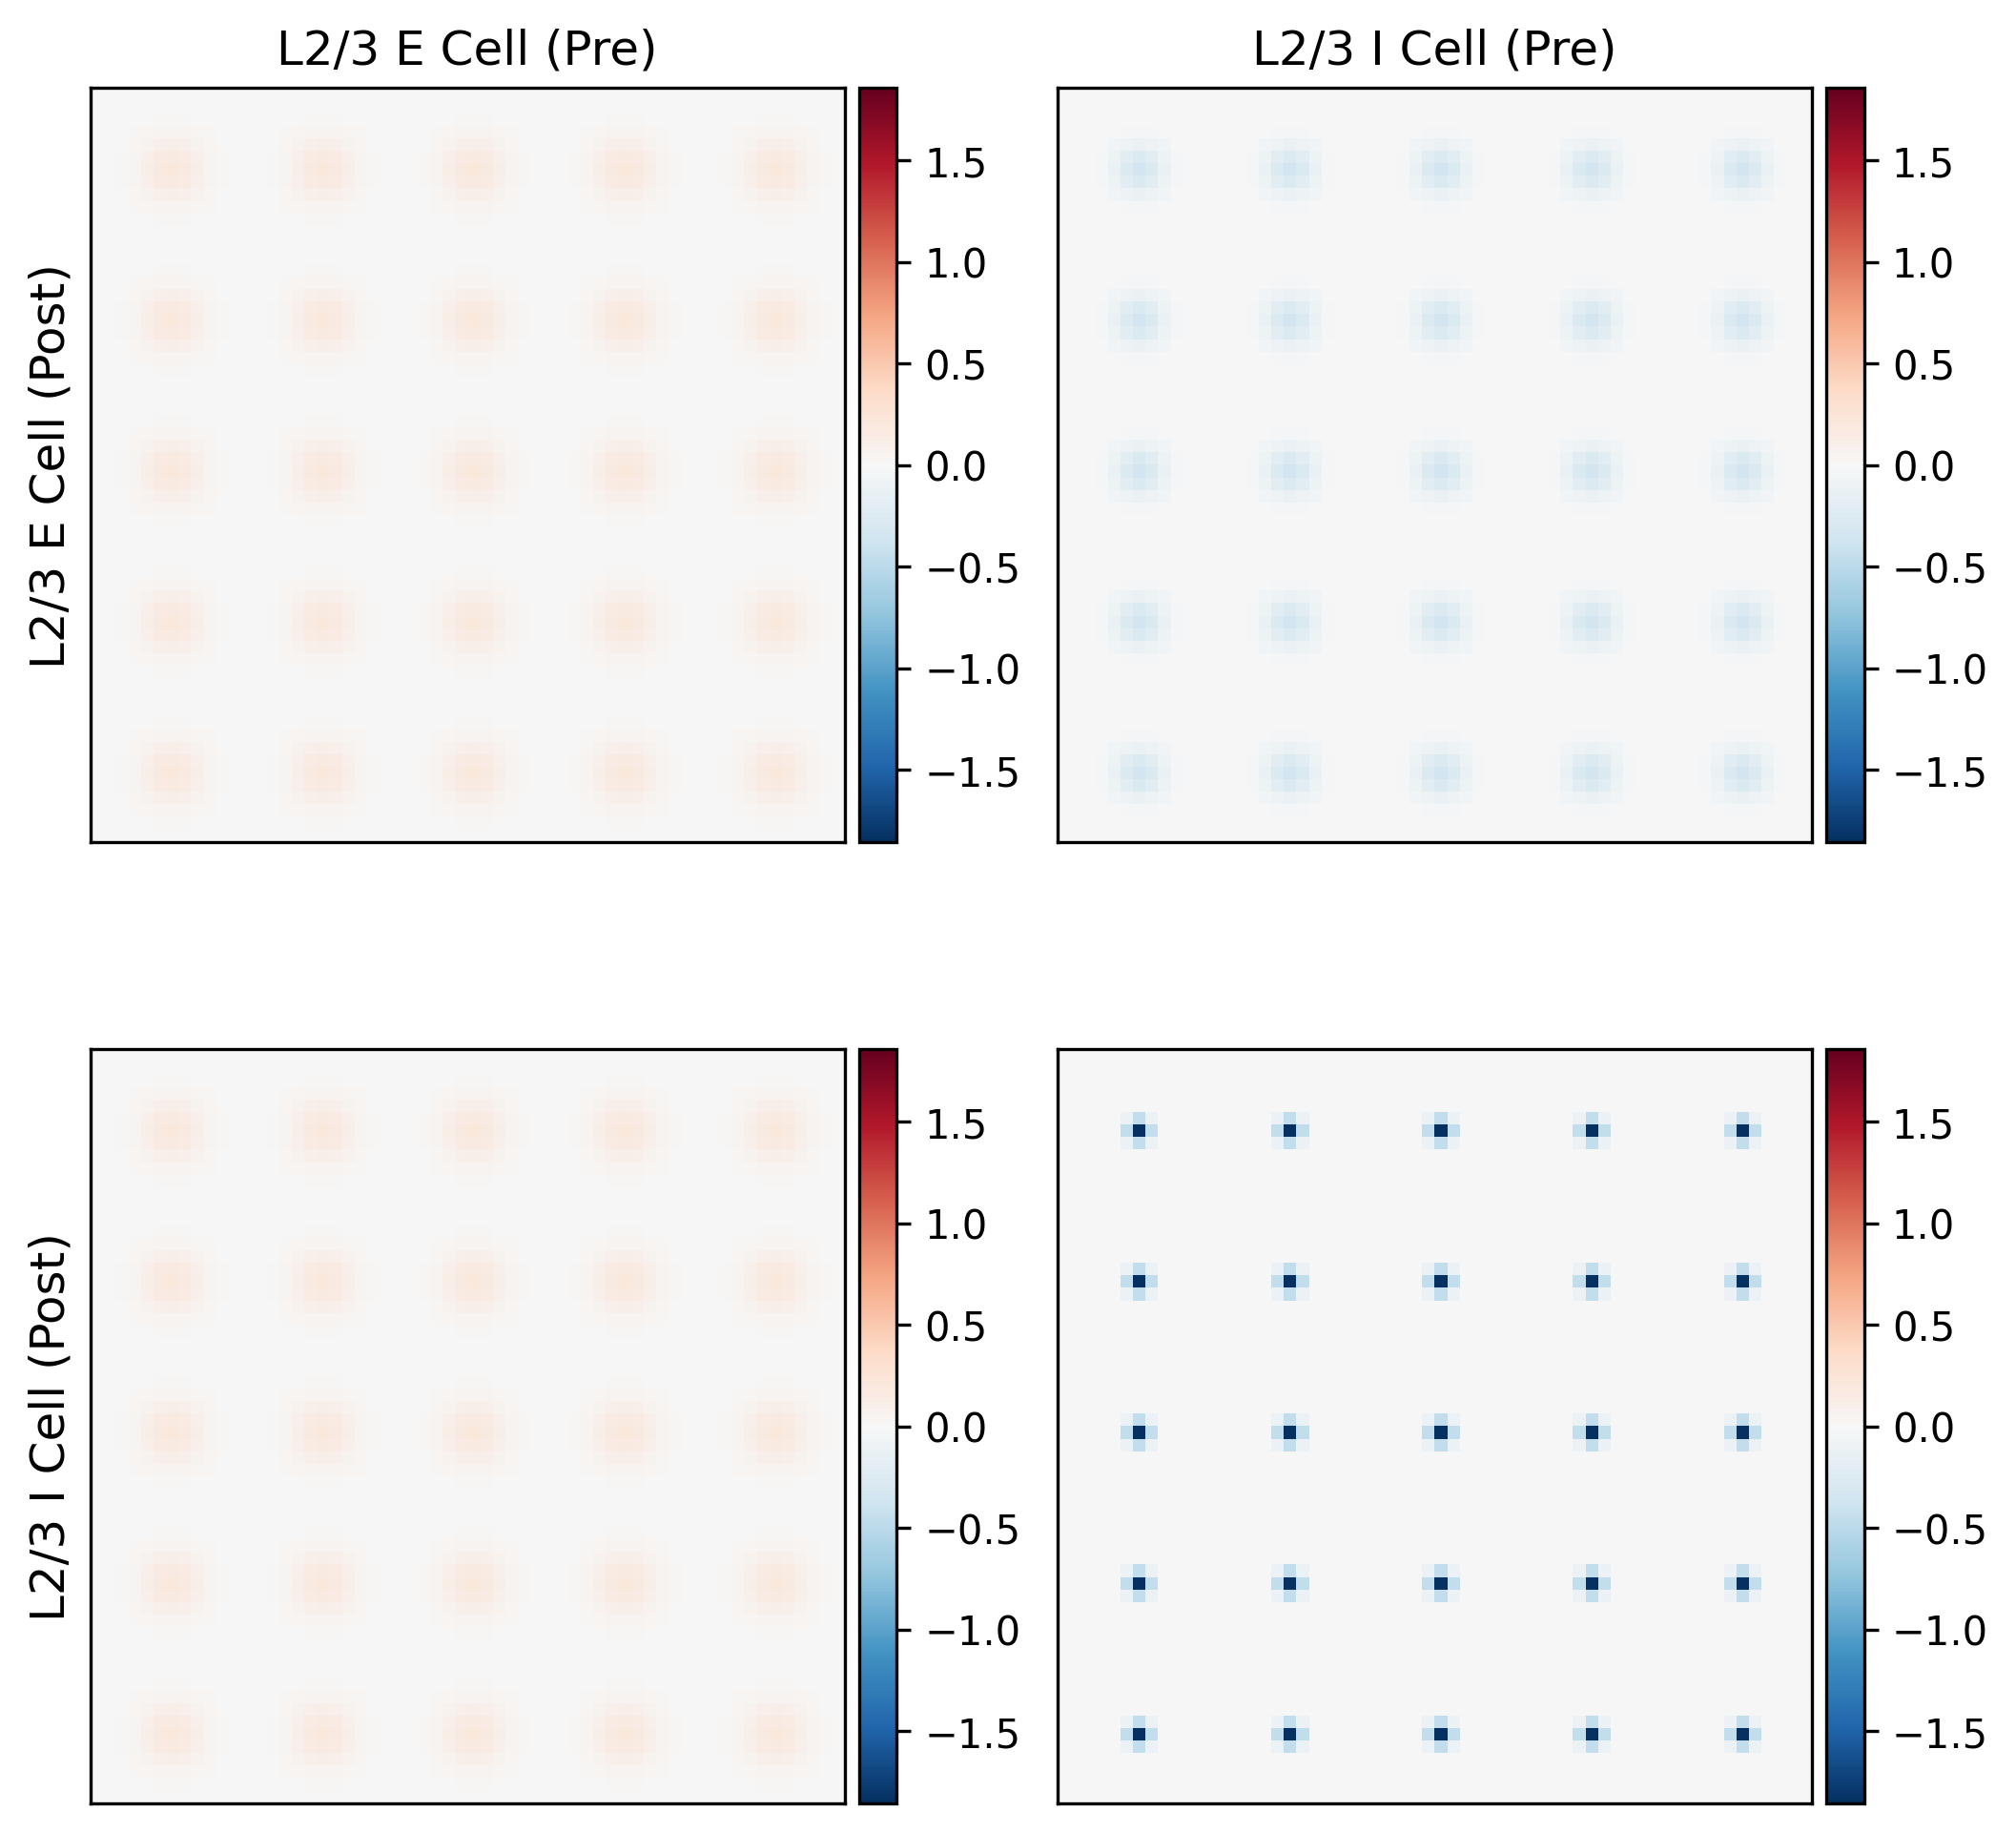

In [5]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//10,N4,N4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += W4to4[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += W4to4[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += W4to4[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += W4to4[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

# Simulate dynamics with white-noise inputs

Text(0.5, 1.0, 'Noise Strength')

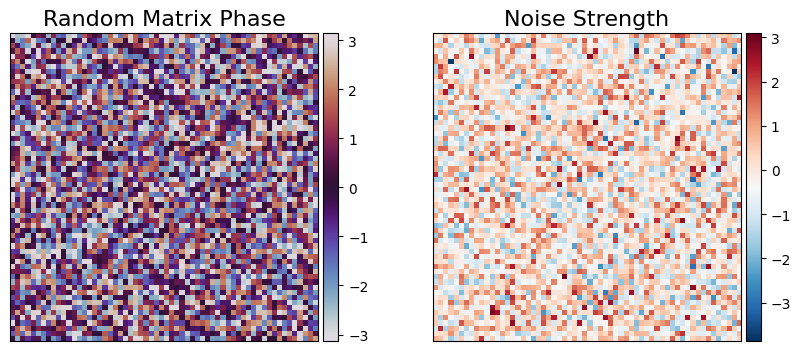

In [6]:
reload(gen_gaussian_random_field)

fig,axs = plt.subplots(1,2,figsize=(10,4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))
random_matrix = np.fft.fft2(np.random.default_rng(0).normal(size=(N4,N4)))
# random_matrix = np.exp(-1j * np.angle(np.fft.fft2(np.random.randn(N4,N4))))
# ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
ring_ifft = np.real(np.fft.ifft2(random_matrix))
ring_ifft = ring_ifft - np.mean(ring_ifft)
ring_ifft = ring_ifft/np.std(ring_ifft)

# pf.imshowbar(fig,axs[0],ring_image,cmap='viridis')
pf.imshowbar(fig,axs[0],np.angle(random_matrix),cmap='twilight')
pf.imshowbar(fig,axs[1],ring_ifft,cmap='RdBu_r')

axs[0].set_title('Random Matrix Phase',fontsize=16)
axs[1].set_title('Noise Strength',fontsize=16)

In [7]:
n_inp = 100
eta = 1e-2
inps = np.zeros((n_inp,2,N4,N4))

# ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,0,N4/4))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
#         ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        ring_ifft = np.real(np.fft.ifft2(random_matrix))
        ring_ifft = ring_ifft - np.mean(ring_ifft)
        ring_ifft = ring_ifft/np.std(ring_ifft)
        inps[inp_idx,pop_idx,:,:] = 1 + eta*ring_ifft

In [8]:
# rates = np.zeros_like(inps)

# start = time.process_time()

# for inp_idx in range(n_inp):
#     rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100)
    
# print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('homo_rates_N4={:d}'.format(N4),rates.flatten())

rates = np.load('homo_rates_N4={:d}.npy'.format(N4)).reshape((n_inp,2,N4,N4))

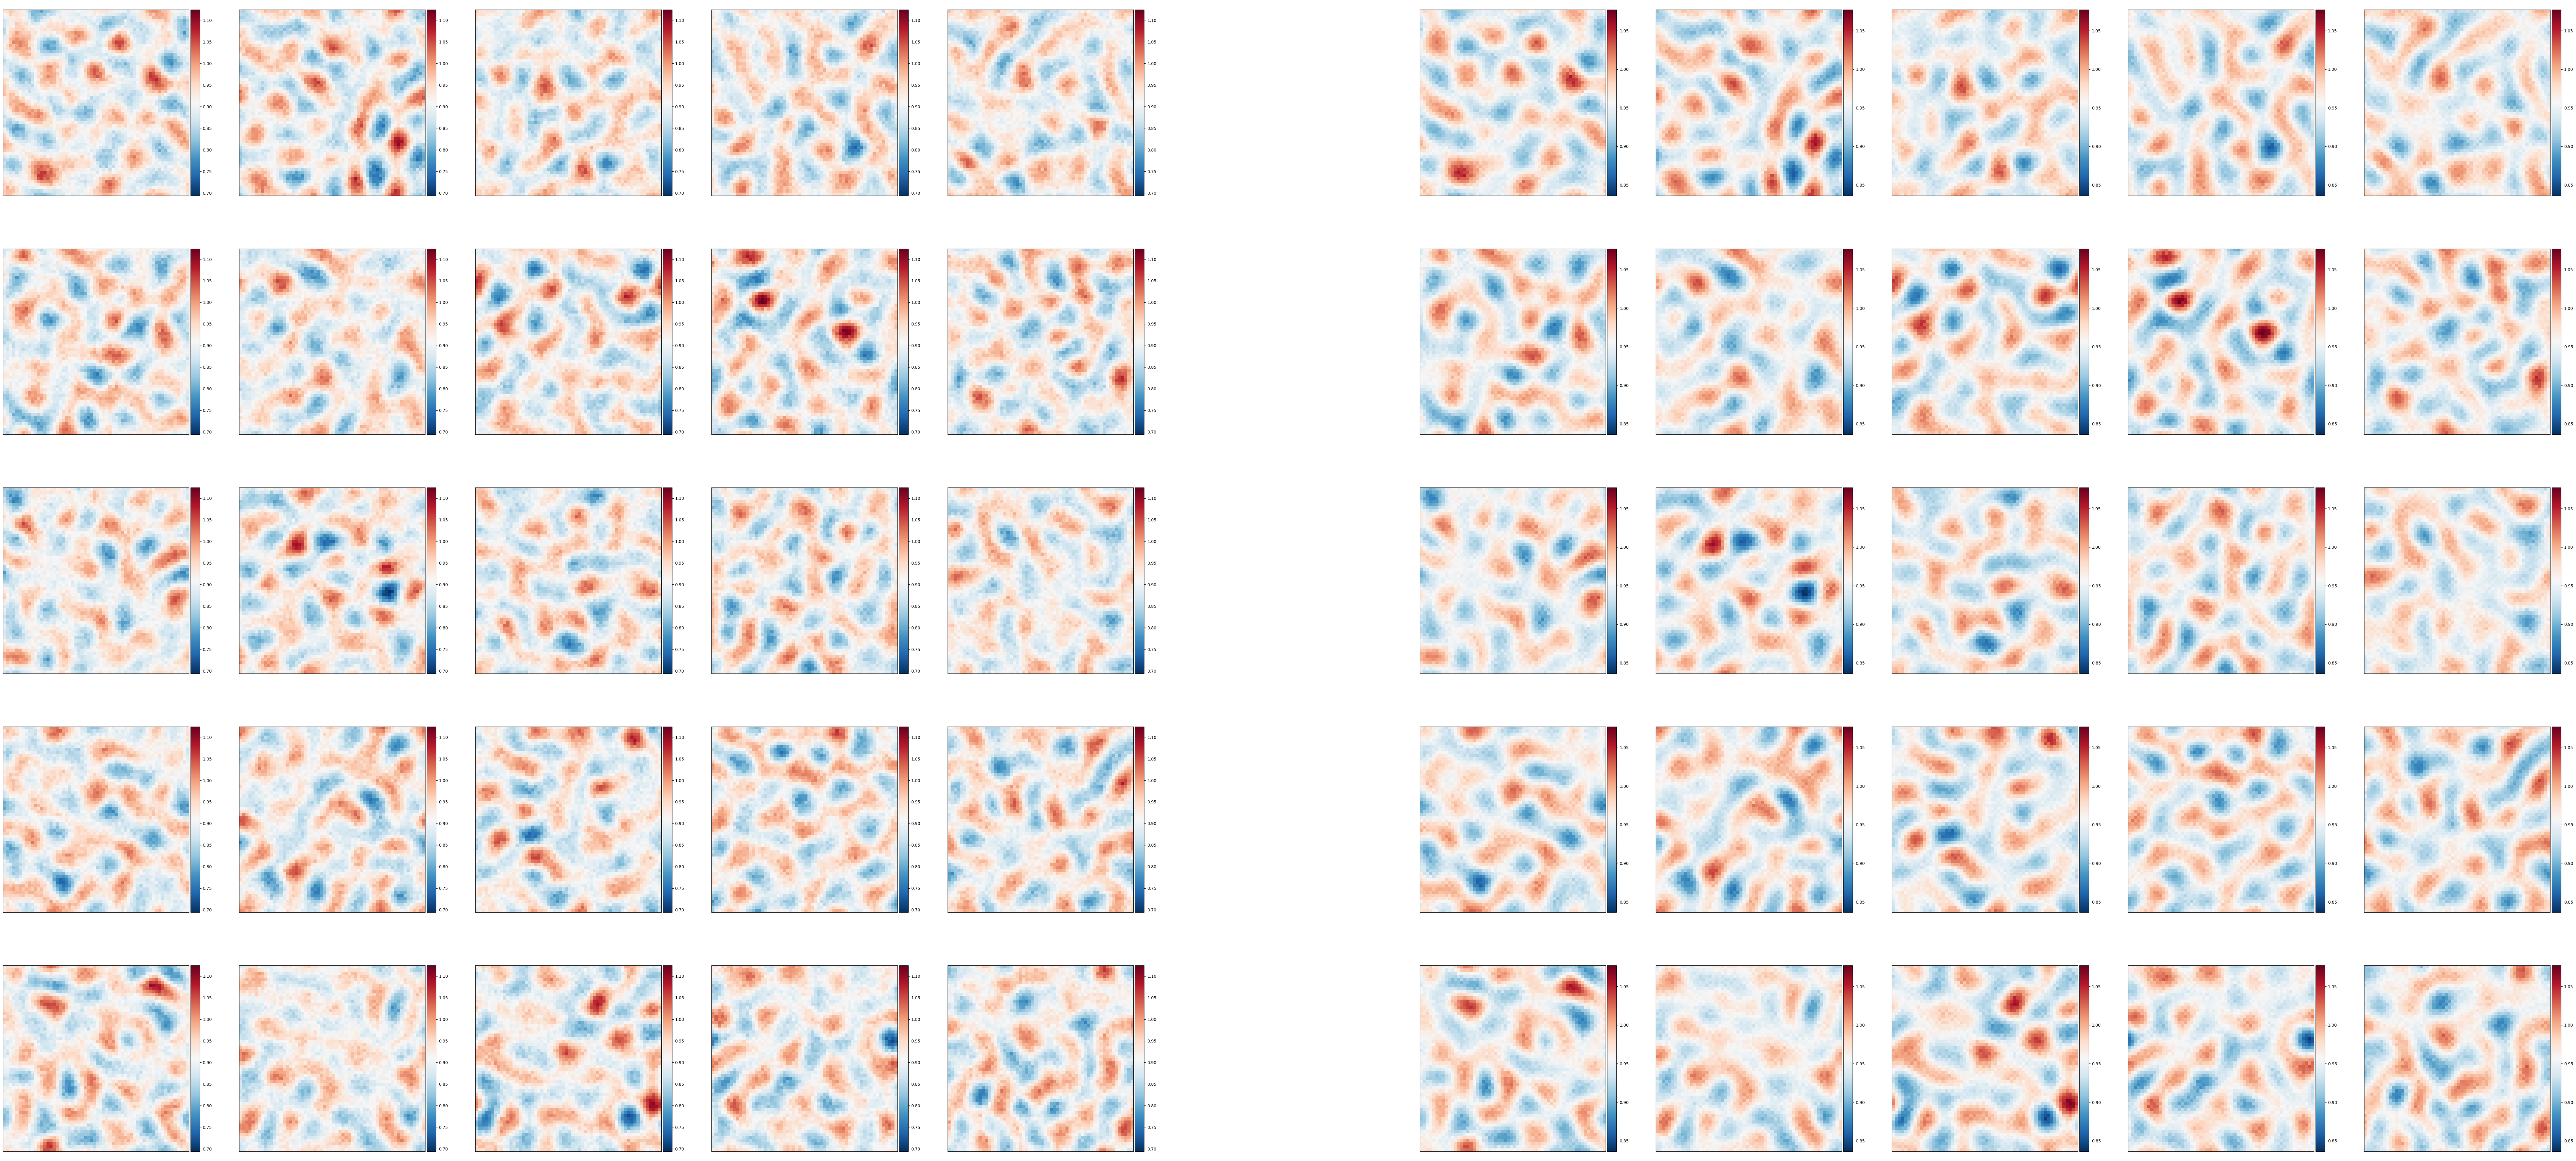

In [9]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50))

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

# Calculate the typical length scale

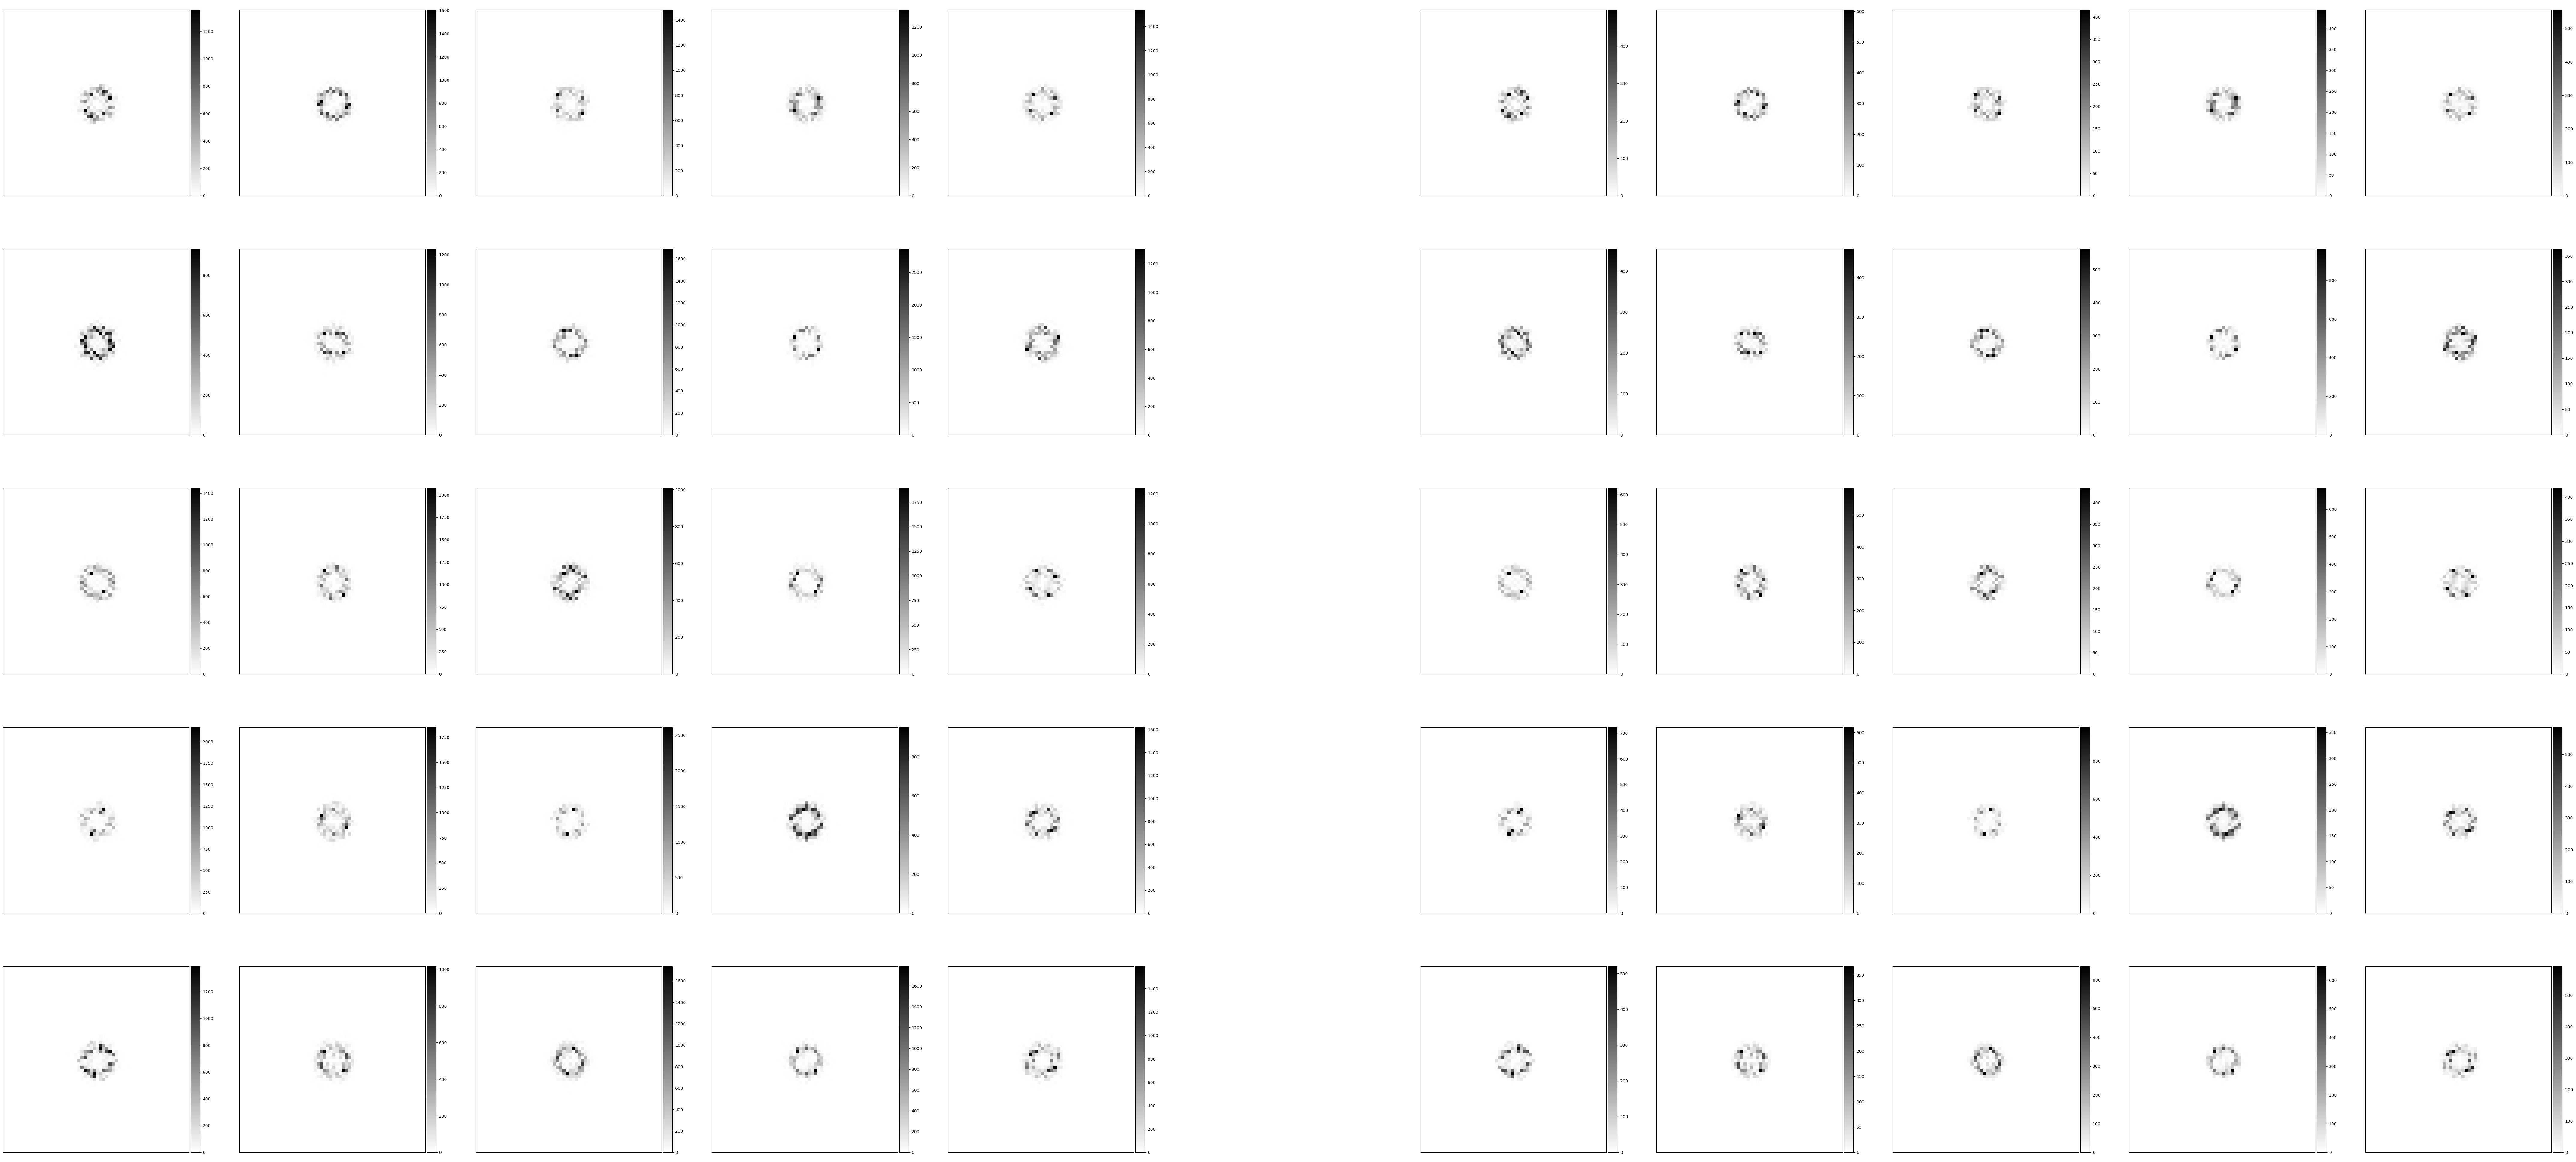

In [10]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50))

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2,
                     cmap='binary')
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2,
                     cmap='binary')

In [11]:
# fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
fps_dat = np.zeros(N4//2)
fps_err = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.5)

for i in range(10):
    for j in range(10):
        idx = i*10+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for idx in range(N4//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for idx in range(N4//2):
            fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            fps_err[idx] += np.var(fp2[bin_idxs == idx])

fps_dat /= 2*n_inp
fps_err /= 2*n_inp
fps_err = np.sqrt(fps_err / (2*n_inp))
# fps_dat /= n_inp
# fps_err /= n_inp
# fps_err = np.sqrt(fps_err / n_inp)

(0.0, 26.95423177338127)

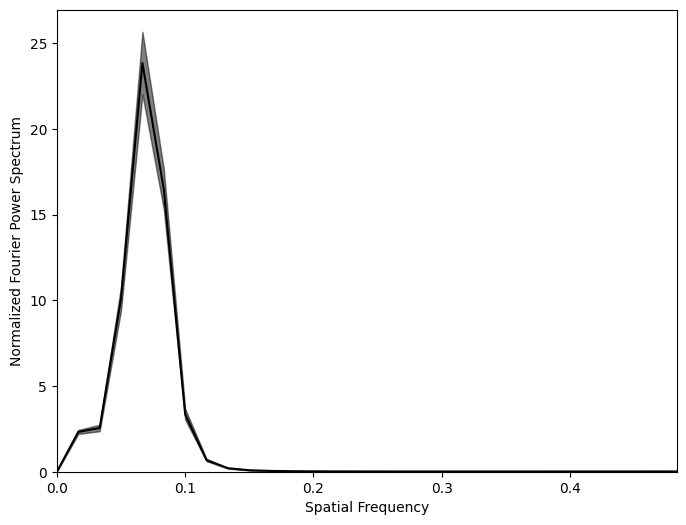

In [12]:
fig,axs = plt.subplots(1,1,figsize=(8,6))

# freqs = np.arange(int(np.ceil(N4//2*np.sqrt(2))))/N4
freqs = np.arange(N4//2)/N4

axs.plot(freqs,fps_dat/np.sum(fps_dat)*N4,'k')
axs.fill_between(freqs,(fps_dat+fps_err)/np.sum(fps_dat)*N4,
                 (fps_dat-fps_err)/np.sum(fps_dat)*N4,
                 color='k',alpha=0.5)

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

In [13]:
Lam = 1/freqs[np.argmax(fps_dat)]
print('Λ =',Lam)

Λ = 15.0


# Construct heterogeneous recurrent weights

In [14]:
config_name = "big_hetero"
Version = -1
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4,rA = uf.get_network_size(config_name)
    
# W4 = connectivity.Connectivity_2pop((N4,N4),(N4,N4),\
#                                     (N4,N4), (N4,N4),\
#                                     random_seed=config_dict["random_seed"],\
#                                     Nvert=1, verbose=True)

# start = time.process_time()

# W4to4,arbor4to4 = W4.create_matrix_2pop(config_dict["W4to4_params"],config_dict["W4to4_params"]["Wrec_mode"])

# print('Creating heterogeneous recurrent connectivity took',time.process_time() - start,'s')
# np.save('hetero_W4to4_N4={:d}'.format(N4),W4to4)

W4to4 = np.load('hetero_W4to4_N4={:d}.npy'.format(N4))

MISC params_dict params_big_hetero {'Nret': 60, 'Nlgn': 60, 'N4': 60, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_ec

Text(0.5, 1.0, 'L2/3 I Cell (Pre)')

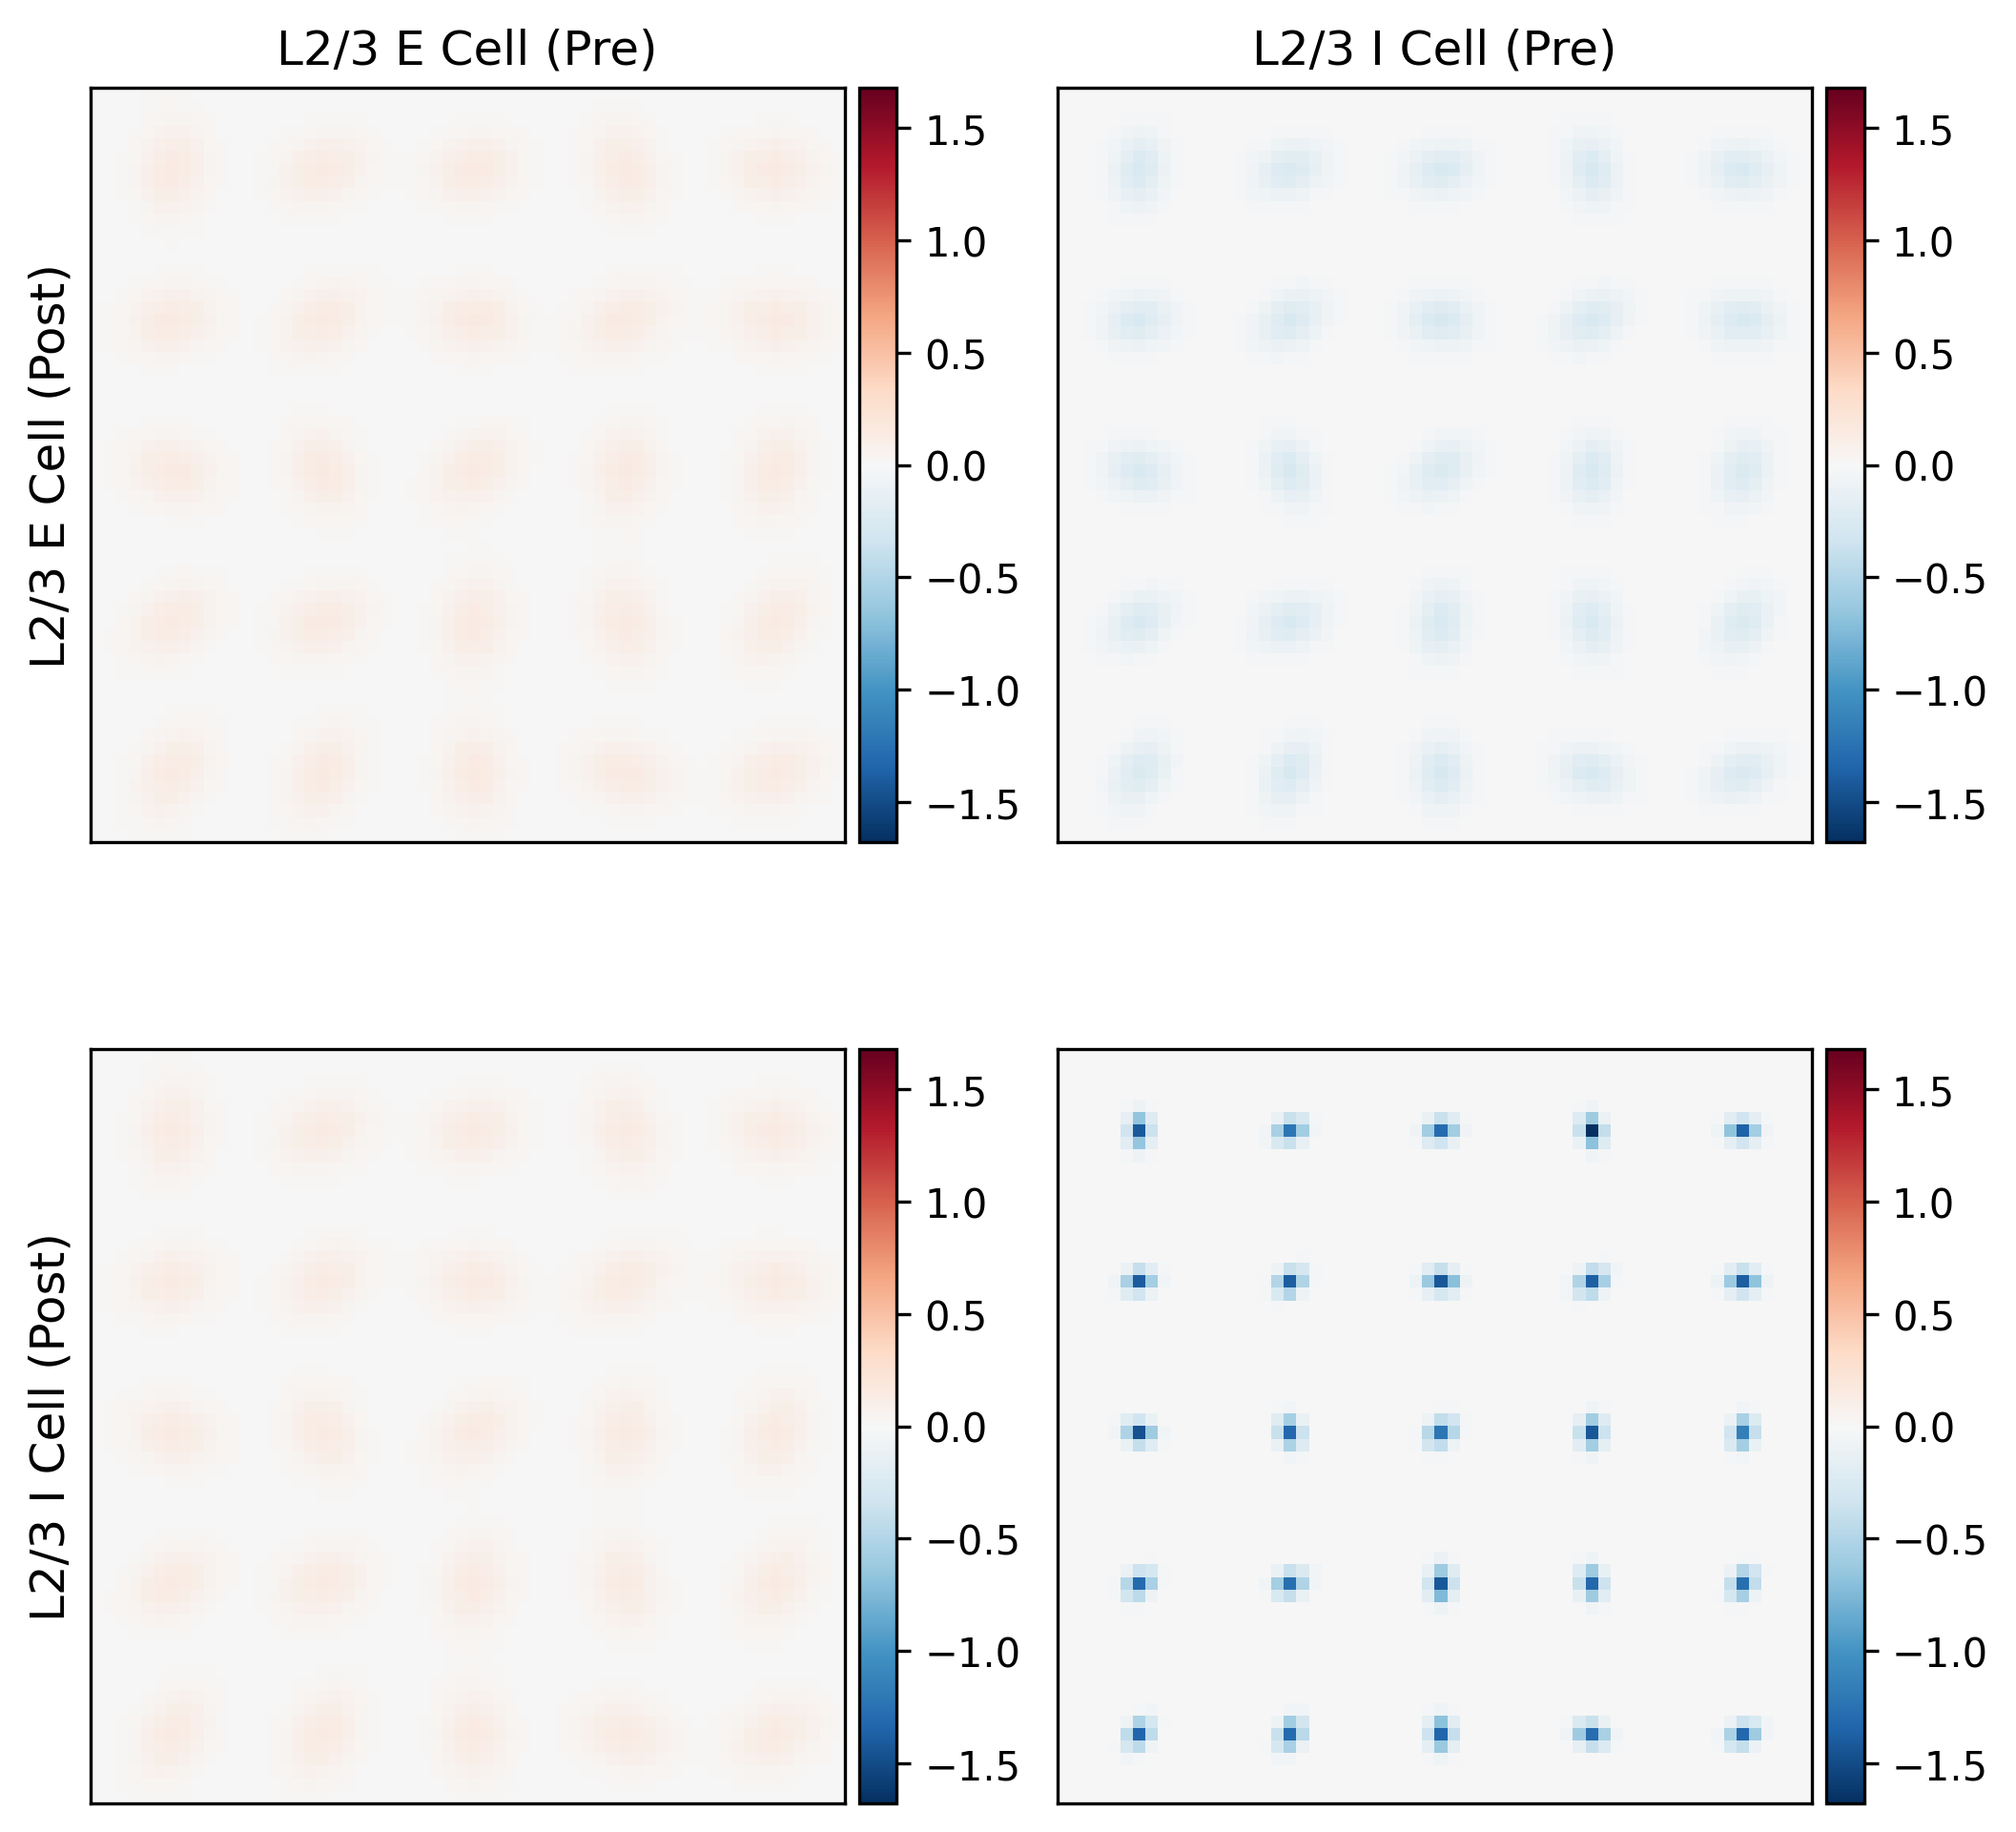

In [15]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

WEE = np.zeros((N4,N4))
WEI = np.zeros((N4,N4))
WIE = np.zeros((N4,N4))
WII = np.zeros((N4,N4))

idxs = np.arange(N4//10,N4,N4//5)
for i in range(len(idxs)):
    for j in range(len(idxs)):
        rav_idx = np.ravel_multi_index([[idxs[i]],[idxs[j]]],(N4,N4))
        WEE += W4to4[:N4**2,:N4**2][:,rav_idx].reshape(N4,N4)
        WEI += W4to4[:N4**2,N4**2:][:,rav_idx].reshape(N4,N4)
        WIE += W4to4[N4**2:,:N4**2][:,rav_idx].reshape(N4,N4)
        WII += W4to4[N4**2:,N4**2:][:,rav_idx].reshape(N4,N4)

pf.imshowbar(fig,axs[0,0],WEE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[0,1],WEI,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,0],WIE,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')
pf.imshowbar(fig,axs[1,1],WII,
            vmin=-np.max(np.abs(W4to4)),vmax=np.max(np.abs(W4to4)),cmap='RdBu_r')

axs[0,0].set_ylabel('L2/3 E Cell (Post)',fontsize=12)
axs[1,0].set_ylabel('L2/3 I Cell (Post)',fontsize=12)
axs[0,0].set_title('L2/3 E Cell (Pre)',fontsize=12)
axs[0,1].set_title('L2/3 I Cell (Pre)',fontsize=12)

# eigval,eigvec = sparse.linalg.eigs(W4to4,1,which='LR')
# print(eigval)

# Simulate network with band-passed inputs around typical length scale

In [16]:
print('Λ/L =',Lam/N4)

Λ/L = 0.25


Text(0.5, 1.0, 'Noise Strength')

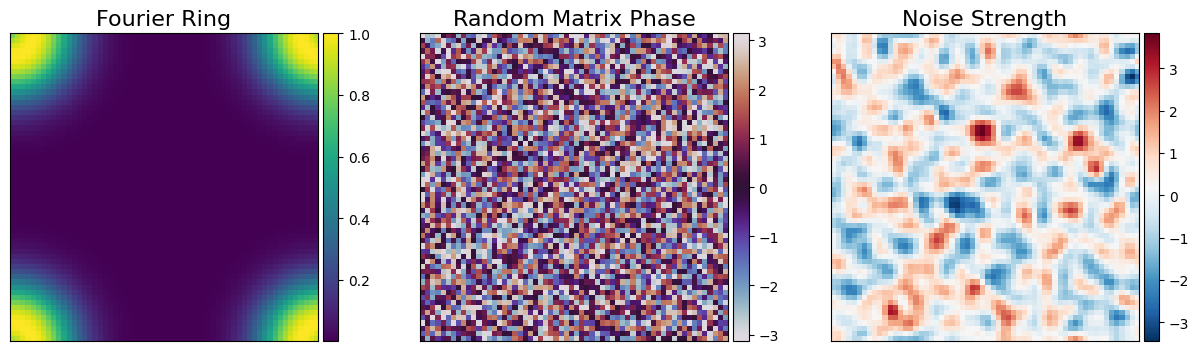

In [17]:
reload(gen_gaussian_random_field)

fig,axs = plt.subplots(1,3,figsize=(15,4))

ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,1/(Lam/N4),N4/10))
random_matrix = np.fft.fft2(np.random.default_rng(0).normal(size=(N4,N4)))
# random_matrix = np.exp(-1j * np.angle(np.fft.fft2(np.random.randn(N4,N4))))
ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
ring_ifft = ring_ifft - np.mean(ring_ifft)
ring_ifft = ring_ifft/np.std(ring_ifft)

pf.imshowbar(fig,axs[0],ring_image,cmap='viridis')
pf.imshowbar(fig,axs[1],np.angle(random_matrix),cmap='twilight')
pf.imshowbar(fig,axs[2],ring_ifft,cmap='RdBu_r')

axs[0].set_title('Fourier Ring',fontsize=16)
axs[1].set_title('Random Matrix Phase',fontsize=16)
axs[2].set_title('Noise Strength',fontsize=16)

In [18]:
n_inp = 100
eta = 1e-2
inps = np.zeros((n_inp,2,N4,N4))

ring_image = np.fft.fftshift(gen_gaussian_random_field.generate_ring(N4,N4,1/(Lam/N4),N4/10))

rng = np.random.default_rng(0)
for inp_idx in range(n_inp):
    for pop_idx in range(2):
        random_matrix = np.fft.fft2(rng.normal(size=(N4,N4)))
        ring_ifft = np.real(np.fft.ifft2(ring_image*random_matrix))
        ring_ifft = ring_ifft - np.mean(ring_ifft)
        ring_ifft = ring_ifft/np.std(ring_ifft)
        inps[inp_idx,pop_idx,:,:] = 1 + eta*ring_ifft

In [19]:
# rates = np.zeros_like(inps)

# start = time.process_time()

# for inp_idx in range(n_inp):
#     rates[inp_idx] = integrate(np.ones(2*N4**2),inps[inp_idx].reshape((2,-1)),0.25,100)
    
# print('Simulating rate dynamics took',time.process_time() - start,'s')
# np.save('hetero_rates_N4={:d}'.format(N4),rates.flatten())

rates = np.load('hetero_rates_N4={:d}.npy'.format(N4)).reshape((n_inp,2,N4,N4))

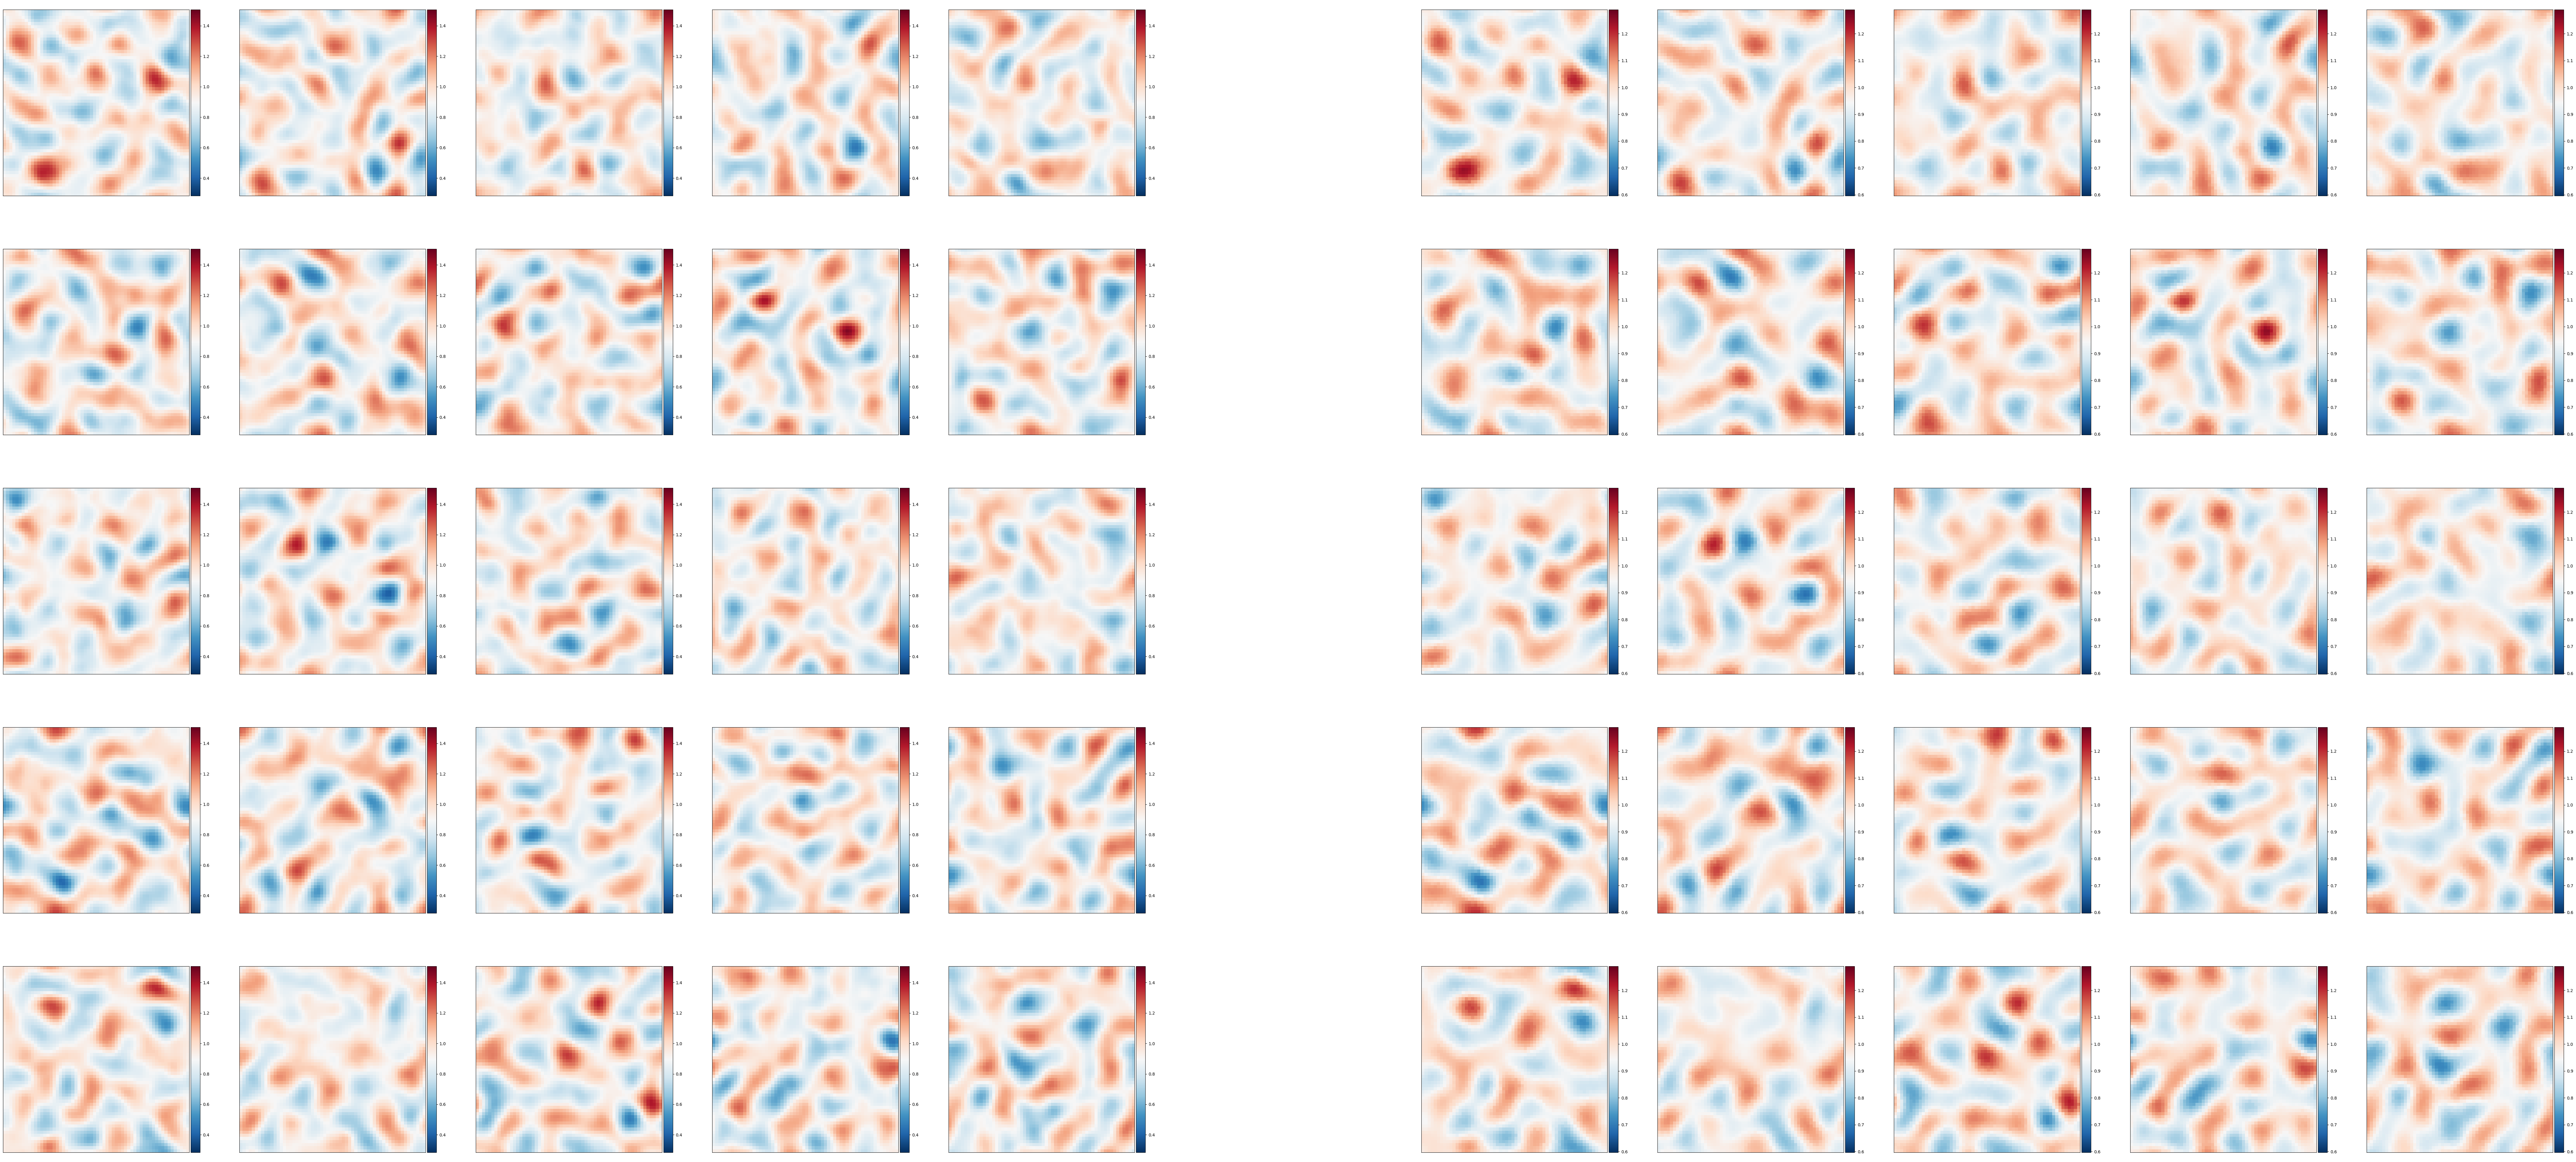

In [20]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50))

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     rates[idx,0],cmap='RdBu_r',
                     vmin=np.min(rates[:,0]),vmax=np.max(rates[:,0]))
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     rates[idx,1],cmap='RdBu_r',
                     vmin=np.min(rates[:,1]),vmax=np.max(rates[:,1]))

# Compare input power spectrum with rate power spectrum

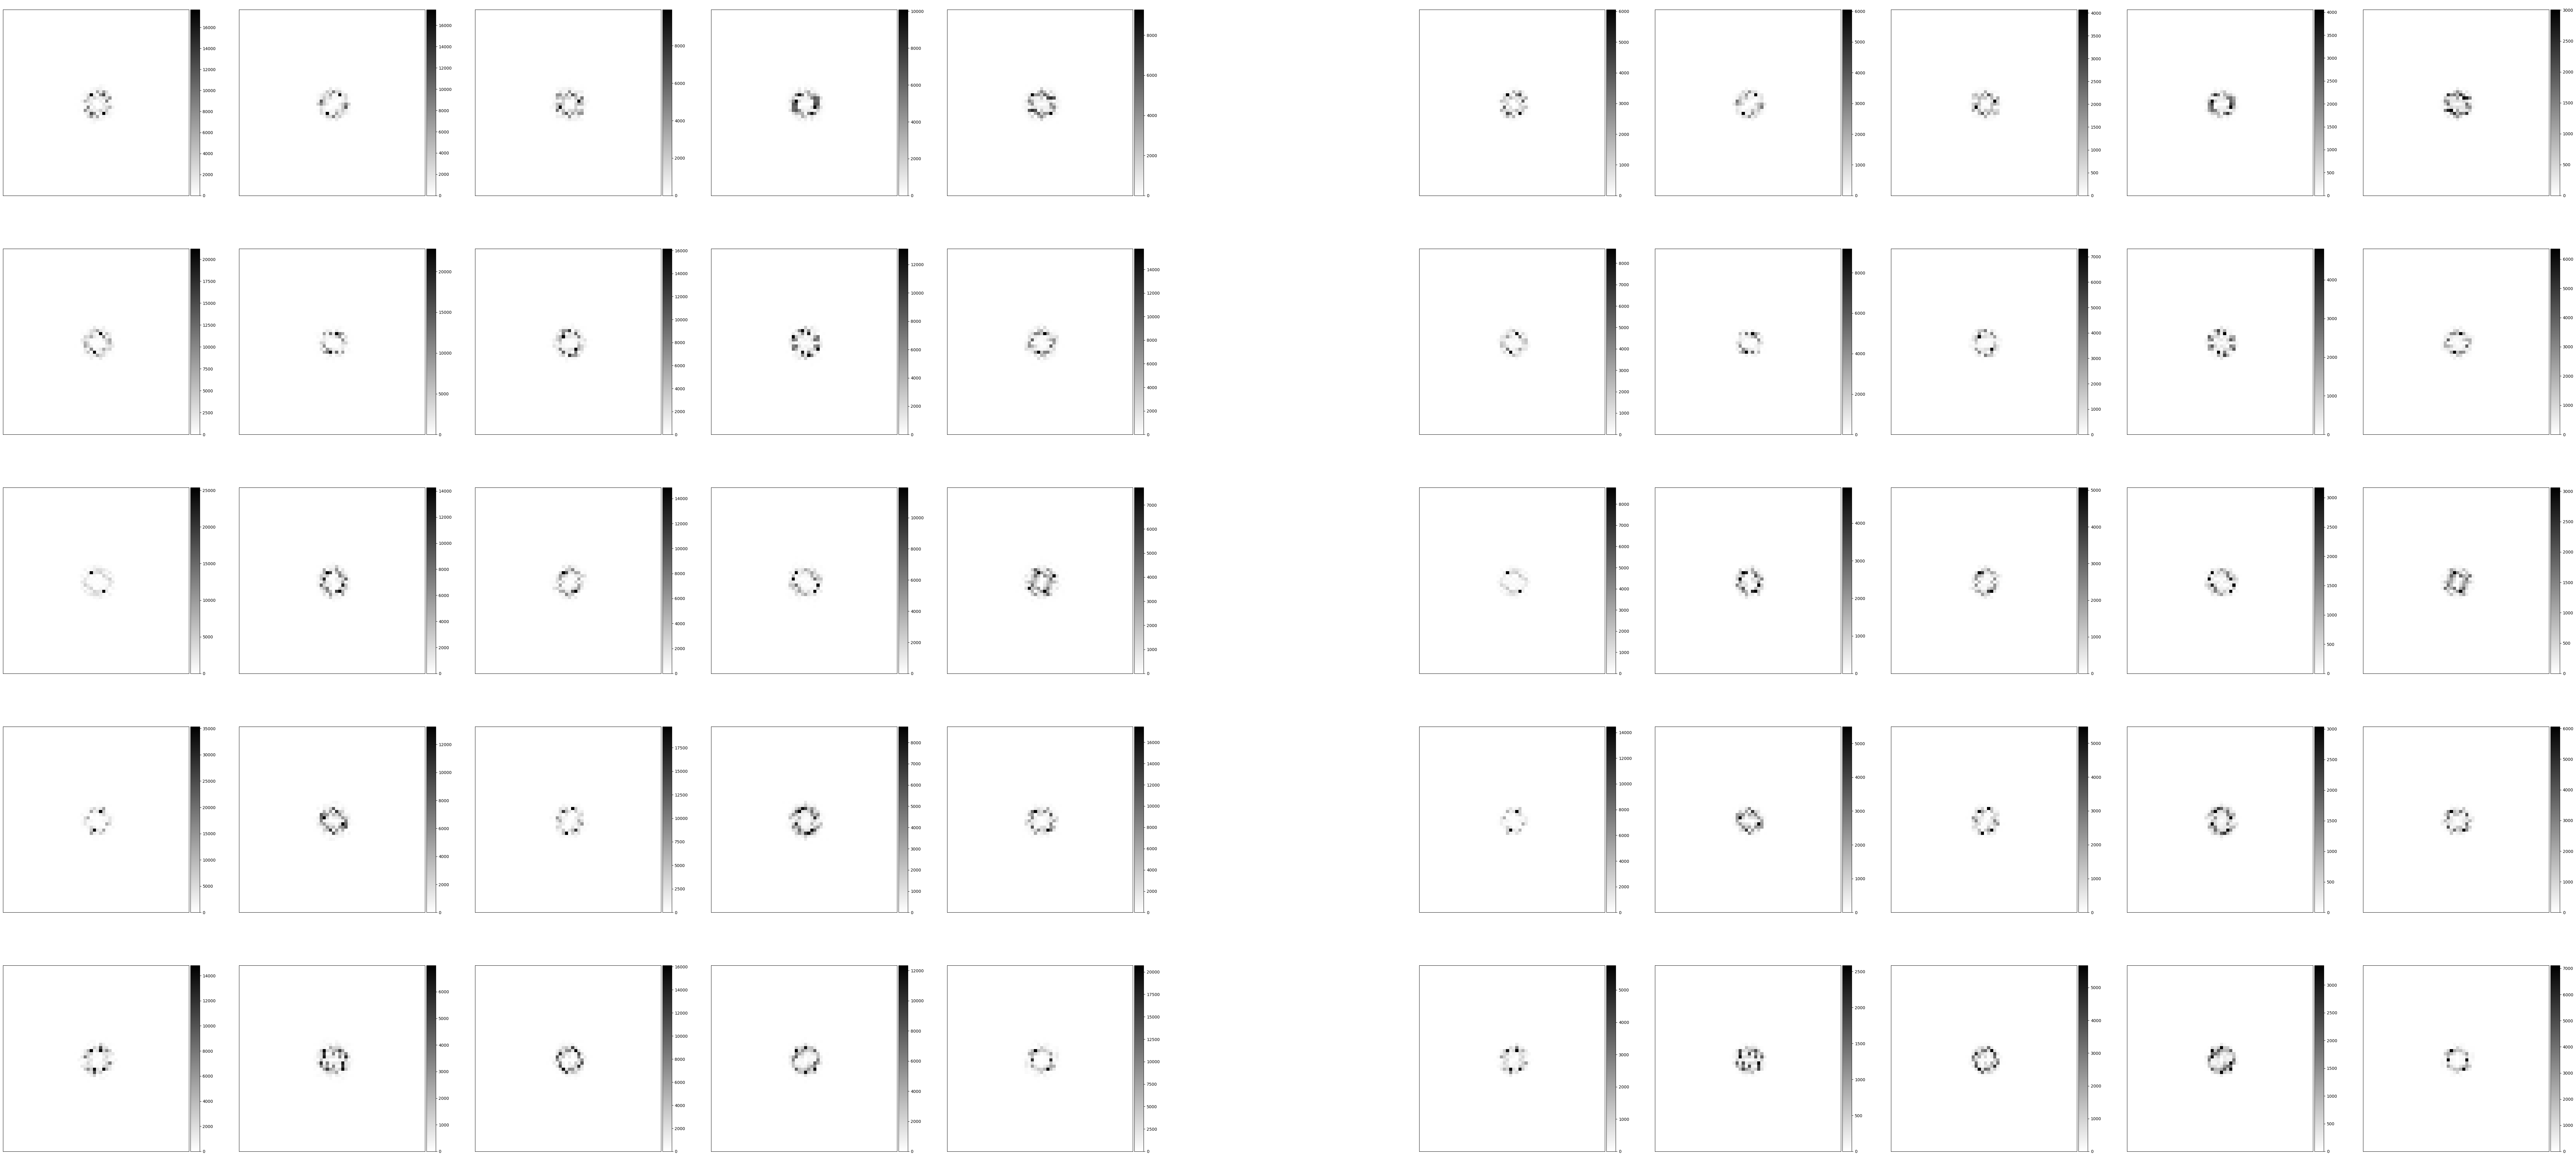

In [21]:
n_row = 5

fig,axs = plt.subplots(n_row,2*n_row+1,figsize=(110,50))

for i in range(n_row):
    axs[i,n_row].axis('off')
    for j in range(n_row):
        idx = i*n_row+j
        pf.imshowbar(fig,axs[i,j],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2,
                     cmap='binary')
        pf.imshowbar(fig,axs[i,n_row+j+1],
                     np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2,
                     cmap='binary')

In [22]:
# inp_fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# inp_fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# rate_fps_dat = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
# rate_fps_err = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))
inp_fps_dat = np.zeros(N4//2)
inp_fps_err = np.zeros(N4//2)
rate_fps_dat = np.zeros(N4//2)
rate_fps_err = np.zeros(N4//2)

grid = np.arange(-N4//2,N4//2)
x,y = np.meshgrid(grid,grid)
bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.1)

for i in range(10):
    for j in range(10):
        idx = i*10+j
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(inps[idx,0]-np.nanmean(inps[idx,0]))))**2
        for idx in range(N4//2):
            inp_fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            inp_fps_err[idx] += np.var(fp2[bin_idxs == idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(inps[idx,1]-np.nanmean(inps[idx,1]))))**2
        for idx in range(N4//2):
            inp_fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            inp_fps_err[idx] += np.var(fp2[bin_idxs == idx])
        
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,0]-np.nanmean(rates[idx,0]))))**2
        for idx in range(N4//2):
            rate_fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            rate_fps_err[idx] += np.var(fp2[bin_idxs == idx])
            
        fp2 = np.abs(np.fft.fftshift(np.fft.fft2(rates[idx,1]-np.nanmean(rates[idx,1]))))**2
        for idx in range(N4//2):
            rate_fps_dat[idx] += np.mean(fp2[bin_idxs == idx])
            rate_fps_err[idx] += np.var(fp2[bin_idxs == idx])

inp_fps_dat /= 2*n_inp
inp_fps_err /= 2*n_inp
inp_fps_err = np.sqrt(inp_fps_err / (2*n_inp))
rate_fps_dat /= 2*n_inp
rate_fps_err /= 2*n_inp
rate_fps_err = np.sqrt(rate_fps_err / (2*n_inp))

(0.0, 36.63117282295953)

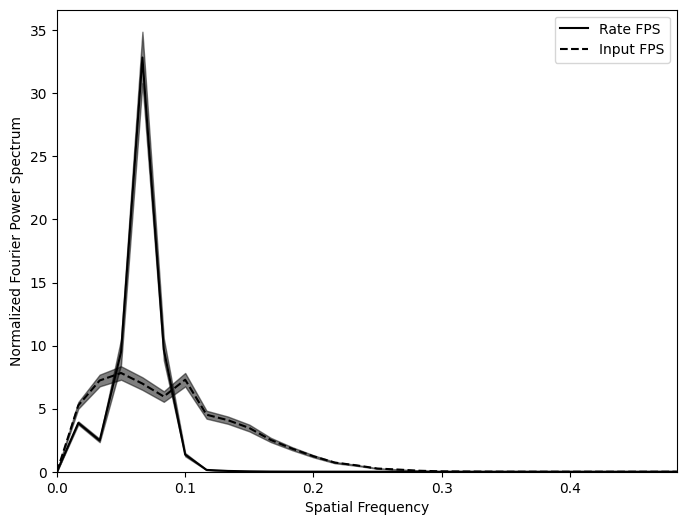

In [23]:
fig,axs = plt.subplots(1,1,figsize=(8,6))

freqs = np.arange(N4//2)/N4

axs.plot(freqs,rate_fps_dat/np.sum(rate_fps_dat)*N4,'k',label='Rate FPS')
axs.fill_between(freqs,(rate_fps_dat+rate_fps_err)/np.sum(rate_fps_dat)*N4,
                 (rate_fps_dat-rate_fps_err)/np.sum(rate_fps_dat)*N4,
                 color='k',alpha=0.5)
axs.plot(freqs,inp_fps_dat/np.sum(inp_fps_dat)*N4,'k--',label='Input FPS')
axs.fill_between(freqs,(inp_fps_dat+inp_fps_err)/np.sum(inp_fps_dat)*N4,
                 (inp_fps_dat-inp_fps_err)/np.sum(inp_fps_dat)*N4,
                 color='k',alpha=0.5)
axs.legend()

axs.set_xlabel('Spatial Frequency')
axs.set_ylabel('Normalized Fourier Power Spectrum')

axs.set_xlim(0,(N4//2-1)/N4)
axs.set_ylim(0,None)

In [24]:
print(1/freqs[np.argmax(rate_fps_dat)])

15.0


# Calculate correlation patterns

In [25]:
rates_sub = rates[:,0] - np.mean(rates[:,0],0)
rates_std = np.std(rates[:,0],0)

start = time.process_time()

rates_cov = np.einsum('ijk,ilm->jklm',rates_sub,rates_sub) / n_inp
rates_corr = rates_cov/(rates_std[:,:,None,None]*rates_std[None,None,:,:])

print('Calculating correlation patterns took',time.process_time() - start,'s')

Calculating correlation patterns took 0.9856899999999911 s


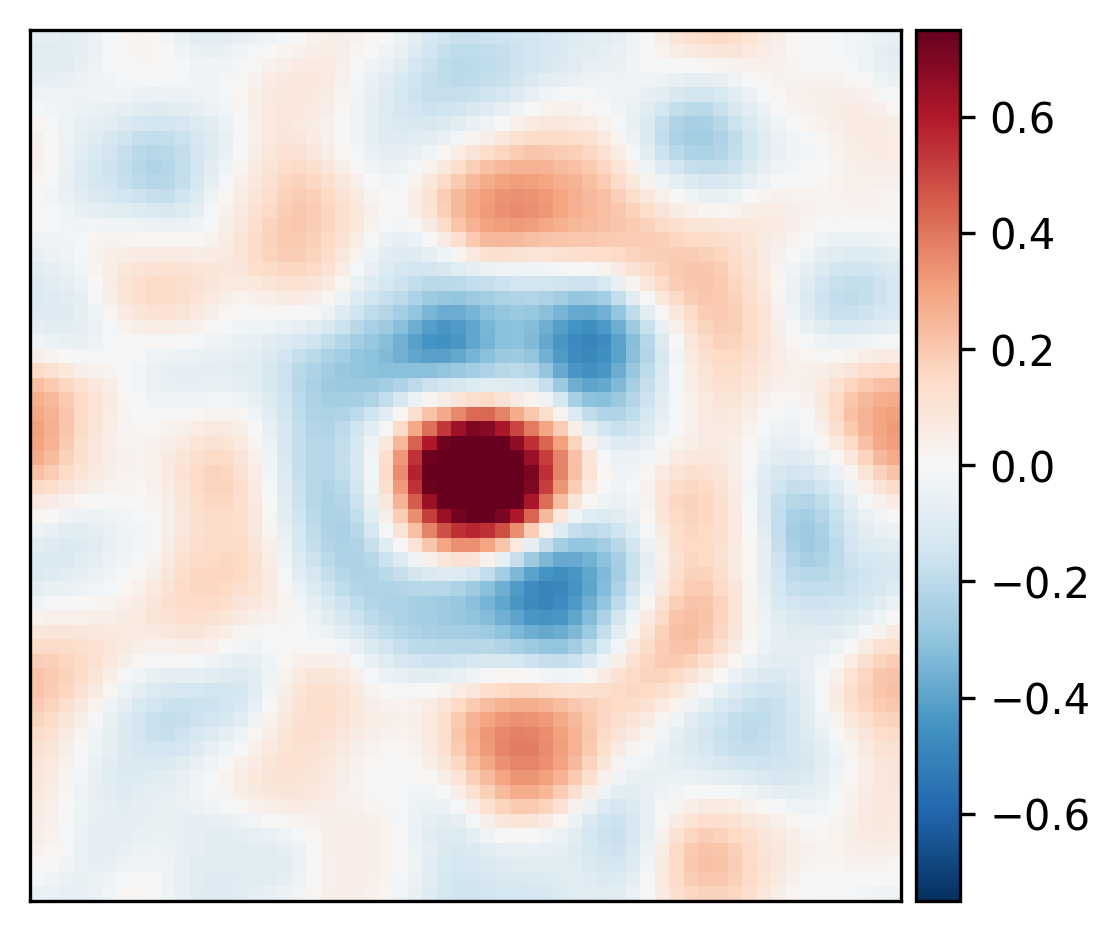

In [26]:
fig,axs = plt.subplots(1,1,figsize=(4,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

seed_idx = (N4//2,N4//2)

pf.imshowbar(fig,axs,rates_corr[seed_idx[0],seed_idx[1],:,:],cmap='RdBu_r',vmin=-0.75,vmax=0.75)

# Calculate Fracture Lines